### imports

In [1]:
import pyspark
import pyspark.sql.functions as F
from pyspark.sql.functions import *
from pyspark.sql.types import (
    StructType, StructField,
    StringType, LongType, DoubleType, TimestampType
)
import pandas as pd
import numpy as np
import os
import sys
import math
from pyspark.sql import SparkSession
from pyspark.context import SparkContext
import matplotlib.pyplot as plt
import pyarrow

## 1. Recommendation Engine with PySpark

In [2]:
# Inicializa a sessão Spark
spark = SparkSession.builder.appName("PMBD - Product_Recommendation") \
    .config("spark.sql.shuffle.partitions", "400") \
    .config("spark.driver.maxResultSize", "4g") \
    .config("spark.sql.execution.arrow.enabled", "true") \
    .config("spark.driver.memory", "4g") \
    .config("spark.executor.cores", "8") \
    .config("spark.executor.memoryOverhead", "4g") \
    .config("spark.executor.instances", "10") \
    .getOrCreate()

spark.sparkContext.setLogLevel("INFO")  # Pode ser ajustado para "INFO" durante o desenvolvimento

In [3]:
print(spark.sparkContext._jsc.sc().isStopped())  # False -> tudo bem; True -> Spark está desligado

False


In [4]:
data_dir = "../data/"
dataRaw_dir = data_dir + "raw/"

schema = StructType([
    StructField("event_time", TimestampType(), True),
    StructField("event_type", StringType(), True),
    StructField("product_id", LongType(), True),
    StructField("category_id", LongType(), True),
    StructField("category_code", StringType(), True),
    StructField("brand", StringType(), True),
    StructField("price", DoubleType(), True),
    StructField("user_id", LongType(), True),
    StructField("user_session", StringType(), True)
])

df = spark.read.parquet(dataRaw_dir + "ec_total.parquet", schema=schema).limit(1000000)

In [5]:
df.printSchema()

root
 |-- event_time: timestamp (nullable = true)
 |-- event_type: string (nullable = true)
 |-- product_id: long (nullable = true)
 |-- category_id: long (nullable = true)
 |-- category_code: string (nullable = true)
 |-- brand: string (nullable = true)
 |-- price: double (nullable = true)
 |-- user_id: long (nullable = true)
 |-- user_session: string (nullable = true)



In [6]:
df.show(5, truncate=False)

+-------------------+----------+----------+-------------------+-----------------------------+--------+-------+---------+------------------------------------+
|event_time         |event_type|product_id|category_id        |category_code                |brand   |price  |user_id  |user_session                        |
+-------------------+----------+----------+-------------------+-----------------------------+--------+-------+---------+------------------------------------+
|2019-11-17 08:43:00|view      |2501799   |2053013564003713919|appliances.kitchen.oven      |elenberg|46.31  |563237118|4368d099-6d19-47cb-95f8-1a235bc2d701|
|2019-11-17 08:43:00|view      |6400335   |2053013554121933129|computers.components.cpu     |intel   |435.28 |551129779|4db2c365-ee85-4437-87ad-23d70bfc01a9|
|2019-11-17 08:43:00|view      |3701538   |2053013565983425517|appliances.environment.vacuum|irobot  |1878.81|539845715|bf7d95c0-69e1-40ff-817b-7118652f018b|
|2019-11-17 08:43:00|view      |26400266  |205301356

## 2. Exploratory Data Analysis

In [7]:
# Null values

df.select([F.count(F.when(F.isnull(c), c)).alias(c) for c in df.columns]).show()

+----------+----------+----------+-----------+-------------+------+-----+-------+------------+
|event_time|event_type|product_id|category_id|category_code| brand|price|user_id|user_session|
+----------+----------+----------+-----------+-------------+------+-----+-------+------------+
|         0|         0|         0|          0|       298678|138910|    0|      0|           0|
+----------+----------+----------+-----------+-------------+------+-----+-------+------------+



In [8]:
# Number of events

df.groupBy('event_type').count().show()

+----------+------+
|event_type| count|
+----------+------+
|      view|898539|
|  purchase| 34619|
|      cart| 66842|
+----------+------+



<Axes: ylabel='count'>

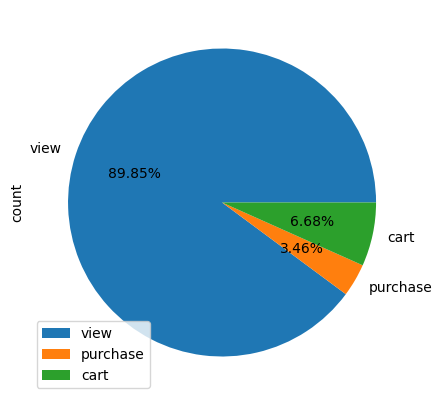

In [9]:
# Plot events distribution

events = df.groupBy('event_type').count().toPandas()
events.plot(kind='pie', y='count', labels=events['event_type'], autopct='%1.2f%%', figsize=(5, 5))

In [10]:
df.select(F.countDistinct("product_id")).show()

+--------------------------+
|count(DISTINCT product_id)|
+--------------------------+
|                     63140|
+--------------------------+



<font size=3>Verificar se todos os produtos pertencem a uma única categoria, agrupando os produtos pelo seu ID, recolhendo os IDs das suas categorias em um conjunto e imprimindo o número de produtos que pertencem a uma única categoria.

In [11]:
df.groupby('product_id').agg(F.collect_set('category_id'))\
                        .filter(size(col('collect_set(category_id)')) == 1).count()

63140

In [12]:
df.select(F.countDistinct("category_id")).show()

+---------------------------+
|count(DISTINCT category_id)|
+---------------------------+
|                        625|
+---------------------------+



In [13]:
df.drop_duplicates(subset=['category_id']).select(F.count("category_code")).show()

+--------------------+
|count(category_code)|
+--------------------+
|                 249|
+--------------------+



In [14]:
df.select(F.countDistinct("category_code")).show()

+-----------------------------+
|count(DISTINCT category_code)|
+-----------------------------+
|                          125|
+-----------------------------+



In [15]:
df.select(F.countDistinct("user_id")).show()

+-----------------------+
|count(DISTINCT user_id)|
+-----------------------+
|                 131954|
+-----------------------+



In [16]:
df.select(F.countDistinct("user_session")).show()

# 13.8m sessions

+----------------------------+
|count(DISTINCT user_session)|
+----------------------------+
|                      189732|
+----------------------------+



<Axes: xlabel='date'>

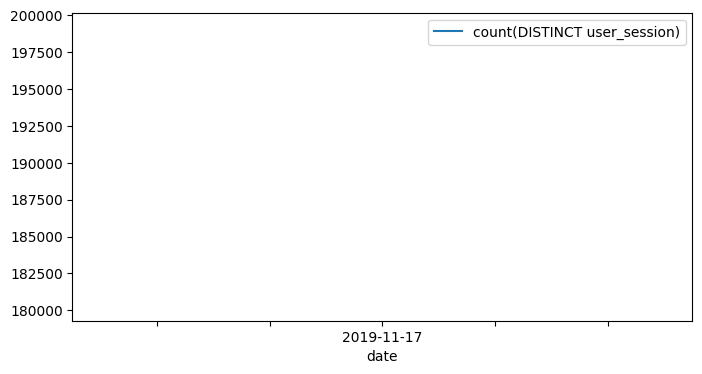

In [17]:
# Plot the daily number of sessions

df = df.withColumn('event_time', to_timestamp('event_time'))
df = df.withColumn('date', date_format("event_time", "yyyy-MM-dd"))

sessions = df.groupby('date').agg(countDistinct('user_session')).toPandas()
sessions.sort_values('date').plot(x='date', figsize=(8, 4))

#TODO: Analisar o tempo médio de cada sessão

In [18]:
# Print the number of interactions between users and products, sorted by carts

interactions = df.groupby(['user_id', 'product_id']).agg(sum(when(df['event_type'] == 'view', 1)).alias('views'),
                                                         sum(when(df['event_type'] == 'cart', 1)).alias('carts'),
                                                         sum(when(df['event_type'] == 'purchase', 1)).alias('purchases'))
interactions.sort('carts', ascending=False).show()

+---------+----------+-----+-----+---------+
|  user_id|product_id|views|carts|purchases|
+---------+----------+-----+-----+---------+
|572519860|   1004751|    1|  129|     NULL|
|536564855|   1005100|    4|  125|        1|
|515078645|   3601537|    2|  115|     NULL|
|572540699|   1004858|    4|   56|     NULL|
|513457523|  28715574|    3|   48|        1|
|559680352|   3601278|    7|   45|        1|
|537735333|   2900513|    7|   43|        1|
|515453227|   1005070|    1|   43|        1|
|512570758|   4000169|    4|   40|        1|
|539546511|   1004258|    2|   40|        1|
|540819402|  17200530|   11|   40|        1|
|547343879|   1004833|    6|   36|        1|
|572513300|   3601347|    3|   34|        1|
|512823792|  26400280|    1|   33|        1|
|571767726| 100005527|    6|   33|        1|
|572514899|   1004856|   14|   32|        8|
|527931349|   8500142|    3|   32|        1|
|527382356|   1005160|    2|   30|        1|
|559683597|   1005177|    4|   29|     NULL|
|567354083

Os dados revelam um número significativo de pares utilizador-produto com um grande número de adições ao carrinho, mas muito poucas visualizações e compras.

Uma análise adicional mostra que muitos desses eventos de adição ao carrinho ocorreram durante a mesma sessão, o que pode ser devido a utilizadores a adicionar e remover repetidamente o produto.

No entanto, os dados não contêm informações sobre eventos de remoção do carrinho, por isso devemos restringir o número de adições ao carrinho a uma por sessão para cada par utilizador-produto.

## 3. Preprocess

In [19]:
def preprocess(df):
    
    # Change data types
    df = df.withColumn('event_time', to_timestamp('event_time'))
    df = df.withColumn('user_id', col('user_id').cast('integer'))
    df = df.withColumn('product_id', col('product_id').cast('integer'))
    df = df.withColumn('category_id', col('category_id').cast('long'))
    
    # Limit the number of carts to 1 per session for each user-product pair
    cart_df = df.filter(col('event_type') == 'cart')
    df = df.filter(col('event_type') != 'cart')
    cart_df = cart_df.dropDuplicates(subset=['product_id', 'user_id', 'user_session'])
    df = df.union(cart_df)
    
    # Split category codes into sub categories
    #df = df.withColumn('category', split(df['category_code'], '\.').getItem(0)) \
    #   .withColumn('sub_category', split(df['category_code'], '\.').getItem(1)) \
    #   .withColumn('sub_sub_category', split(df['category_code'], '\.').getItem(2))

    return df

In [20]:
df = preprocess(df)
df.show(5, truncate=False)

+-------------------+----------+----------+-------------------+-----------------------------+--------+-------+---------+------------------------------------+----------+
|event_time         |event_type|product_id|category_id        |category_code                |brand   |price  |user_id  |user_session                        |date      |
+-------------------+----------+----------+-------------------+-----------------------------+--------+-------+---------+------------------------------------+----------+
|2019-11-17 08:43:00|view      |2501799   |2053013564003713919|appliances.kitchen.oven      |elenberg|46.31  |563237118|4368d099-6d19-47cb-95f8-1a235bc2d701|2019-11-17|
|2019-11-17 08:43:00|view      |6400335   |2053013554121933129|computers.components.cpu     |intel   |435.28 |551129779|4db2c365-ee85-4437-87ad-23d70bfc01a9|2019-11-17|
|2019-11-17 08:43:00|view      |3701538   |2053013565983425517|appliances.environment.vacuum|irobot  |1878.81|539845715|bf7d95c0-69e1-40ff-817b-7118652f018

## 4. Feature Engineering

Podemos extrair várias características para utilizadores, produtos e categorias utilizando os dados comportamentais:

- **Visualizações/carrinhos/compras**: O número de vezes que um utilizador interagiu com um produto.

- **Produtos distintos visualizados/adicionados ao carrinho/comprados**: O número de produtos únicos que um utilizador visualizou, adicionou ao carrinho ou comprou.

- **Preço médio (relativo) visualizado/comprado**: O preço médio dos produtos que um utilizador visualizou ou comprou.

- **Taxas de interação**: São características derivadas que fornecem informações sobre o comportamento dos utilizadores, como a taxa de compras por visualização, carrinho por visualização e compras por carrinho.

In [21]:
def product_features(df):

    # Calculate several metrics for products with the aggregate function
    df = df.groupby('product_id').agg(first('category_id').alias('category_id'),
                                      first('category_code').alias('category_code'),
                                      count(when(df['event_type'] == 'view', True)).alias('views'),
                                      count(when(df['event_type'] == 'cart', True)).alias('carts'),
                                      count(when(df['event_type'] == 'purchase', True)).alias('purchases'),
                                      mean('price').alias('price'),
                                      min('event_time').alias('first_date'),
                                      max('event_time').alias('last_date'))
    
    # Calculate interaction rates
    df = df.withColumn('purchase_per_view', df['purchases'] / df['views'])
    df = df.withColumn('cart_per_view', df['carts'] / df['views'])
    df = df.withColumn('purchase_per_cart', when(df['carts'] == 0, df['purchases']).otherwise(df['purchases'] / df['carts']))
    
    return df

In [22]:
def category_features(df):
    
    # Calculate the average product price for each category
    products = df.dropDuplicates(subset=['product_id'])
    products = products.groupby('category_id').agg(avg('price').alias('average_price'))

    # Calculate several metrics for categories with the aggregate function
    df = df.groupby('category_id').agg(first('category_code').alias('category_code'),
                                       countDistinct('product_id').alias('number_of_products'),
                                       count(when(df['event_type'] == 'view', True)).alias('views'),
                                       count(when(df['event_type'] == 'cart', True)).alias('carts'),
                                       count(when(df['event_type'] == 'purchase', True)).alias('purchases'))
    
    # Calculate interaction rates
    df = df.withColumn('purchase_per_view', df['purchases'] / df['views'])
    df = df.withColumn('cart_per_view', df['carts'] / df['views'])
    df = df.withColumn('purchase_per_cart', when(df['carts'] == 0, df['purchases']).otherwise(df['purchases'] / df['carts']))
    
    df = df.join(products, on='category_id')
    
    return df

In [23]:
def user_features(df):

    # Calculate several metrics for users with the aggregate function
    df = df.groupby('user_id').agg(count(when(df['event_type'] == 'view', True)).alias('views'),
                                   count(when(df['event_type'] == 'cart', True)).alias('carts'),
                                   count(when(df['event_type'] == 'purchase', True)).alias('purchases'),
                                   countDistinct(when(df['event_type'] == 'view', col('product_id'))).alias('distinct_products_viewed'),
                                   countDistinct(when(df['event_type'] == 'cart', col('product_id'))).alias('distinct_products_carted'),
                                   countDistinct(when(df['event_type'] == 'purchase', col('product_id'))).alias('distinct_products_purchased'),
                                   mean(when(df['event_type'] == 'view', col('price'))).alias('average_price_viewed'),
                                   mean(when(df['event_type'] == 'purchase', col('price'))).alias('average_price_purchased'),
                                   mean(when(df['event_type'] == 'view', col('relative_price'))).alias('avg_relative_price_viewed'),
                                   mean(when(df['event_type'] == 'purchase', col('relative_price'))).alias('avg_relative_price_purchased'),
                                   min('event_time').alias('first_date'),
                                   max('event_time').alias('last_date'))
    
    # Calculate interaction rates
    df = df.withColumn('purchase_per_view', when(df['views'] == 0, df['purchases']).otherwise(df['purchases'] / df['views']))
    df = df.withColumn('cart_per_view', when(df['views'] == 0, df['carts']).otherwise(df['carts'] / df['views']))
    df = df.withColumn('purchase_per_cart', when(df['carts'] == 0, df['purchases']).otherwise(df['purchases'] / df['carts']))
    
    return df

Alguns produtos e categorias têm muito poucas interações, o que torna as suas taxas de interação pouco fiáveis. Por exemplo, um produto que foi visualizado apenas 2 vezes e comprado 1 vez teria uma taxa de compras por visualização de 0.5, o que é muito elevado. Por isso, é importante aplicar *smoothing* para evitar *overfitting* em amostras pequenas.

O *smoothing* funciona ao calcular uma média ponderada entre a taxa do produto e a taxa da categoria. O peso dado à taxa do produto depende do número de interações — quanto mais interações, maior o peso. O mesmo tipo de *smoothing* é aplicado às categorias, usando as taxas médias globais de interação.

In [24]:
# Calculate smoothed rates for categories with small sample size using means of all products to combat overfitting
    
def category_smoothener(categories, mean, attr, rate, min_sample_size=1000):
    
    # Weighted average of category value and overall mean
    categories = categories.withColumn(rate, when(categories[attr] < min_sample_size, ((categories[rate] * categories[attr]) + (mean * (min_sample_size - categories[attr]))) / min_sample_size).otherwise(categories[rate]))
    
    return categories

In [25]:
# Calculate smoothed rates for products with small sample size using category means to combat overfitting
    
def product_smoothener(products, categories, attr, rate, min_sample_size=1000):
    
    category_rate = rate + '_cat'
    categories = categories.withColumnRenamed(rate, category_rate)
    products = products.join(categories['category_id', category_rate], on='category_id')
    
    # Weighted average of product value and category value
    products = products.withColumn(rate, when(products[attr] < min_sample_size, ((products[rate] * products[attr]) + (products[category_rate] * (min_sample_size - products[attr]))) / min_sample_size).otherwise(products[rate]))
    
    products = products.drop(category_rate)
    return products

Devemos calcular o preço relativo de cada produto em relação à sua categoria, escalando o seu preço com base na mediana e no intervalo interquartil (IQR) dos preços dessa categoria. A mediana é usada como medida de tendência central e o IQR como medida de variabilidade.

Este escalamento permite compensar diferenças nos intervalos de preços entre categorias, possibilitando uma comparação mais precisa e imparcial dos preços dos produtos. Os preços relativos serão usados para determinar se os utilizadores tendem a interagir com produtos mais baratos ou mais caros.

In [26]:
# Calculate the price of each product relative to its category using the formula: (price - median) / IQR

def calculate_relative_price(products):
    
    categories = products.groupby('category_id').agg(percentile_approx('price', 0.25, 1000).alias('Q1'),
                                                     percentile_approx('price', 0.5, 1000).alias('median'),
                                                     percentile_approx('price', 0.75, 1000).alias('Q3'))
    # Interquartile range
    categories = categories.withColumn('IQR', col('Q3') - col('Q1'))
    categories = categories.withColumn('IQR', when(col('IQR') < 1, 1).otherwise(col('IQR')))
    
    # Calculate relative price
    products = products.join(categories, on='category_id')
    products = products.withColumn('relative_price', (col('price') - col('median')) / col('IQR'))
    
    # In order to avoid extreme values, set the max possible value to 5
    products = products.withColumn('relative_price', when(col('relative_price') > 5, 5).otherwise(col('relative_price')))

    # Set the min possible value to -5
    products = products.withColumn('relative_price', when(col('relative_price') < -5, -5).otherwise(col('relative_price')))

    products = products.select('product_id', 'relative_price')
    return products

In [27]:
# Extract product and category features
products = product_features(df)
products.show(5, truncate=False)

+----------+-------------------+----------------------+-----+-----+---------+------------------+-------------------+-------------------+--------------------+--------------------+------------------+
|product_id|category_id        |category_code         |views|carts|purchases|price             |first_date         |last_date          |purchase_per_view   |cart_per_view       |purchase_per_cart |
+----------+-------------------+----------------------+-----+-----+---------+------------------+-------------------+-------------------+--------------------+--------------------+------------------+
|1000978   |2053013555631882655|electronics.smartphone|40   |0    |0        |300.9099999999999 |2019-11-17 08:55:28|2019-11-17 11:23:08|0.0                 |0.0                 |0.0               |
|1002100   |2053013555631882655|electronics.smartphone|97   |1    |6        |370.63999999999965|2019-11-17 08:43:05|2019-11-17 11:16:59|0.061855670103092786|0.010309278350515464|6.0               |
|1002102  

In [28]:
categories = category_features(df)
categories.show(5, truncate=False)

+-------------------+-----------------------+------------------+-----+-----+---------+--------------------+--------------------+------------------+------------------+
|category_id        |category_code          |number_of_products|views|carts|purchases|purchase_per_view   |cart_per_view       |purchase_per_cart |average_price     |
+-------------------+-----------------------+------------------+-----+-----+---------+--------------------+--------------------+------------------+------------------+
|2060237588744111062|NULL                   |2                 |62   |0    |0        |0.0                 |0.0                 |0.0               |734.4499999999999 |
|2098563460336976001|construction.tools.pump|6                 |10   |1    |1        |0.1                 |0.1                 |1.0               |7.005             |
|2053013564968403895|NULL                   |121               |442  |6    |2        |0.004524886877828055|0.013574660633484163|0.3333333333333333|79.84272727272729 

In [29]:
# Calculate relative prices and append it to the main dataframe and product features
relative_prices = calculate_relative_price(products)
relative_prices.show(5, truncate=False)

+----------+--------------------+
|product_id|relative_price      |
+----------+--------------------+
|8600214   |-0.11178957256928135|
|8600225   |-0.08172851103804604|
|8600036   |-0.15171441991545326|
|8600208   |0.9248473461719117  |
|8600140   |0.2658525129168624  |
+----------+--------------------+
only showing top 5 rows



In [30]:
df = df.join(relative_prices, on='product_id')
df.show(5, truncate=False)

+----------+-------------------+----------+-------------------+-------------------------------+--------+-----+---------+------------------------------------+----------+--------------------+
|product_id|event_time         |event_type|category_id        |category_code                  |brand   |price|user_id  |user_session                        |date      |relative_price      |
+----------+-------------------+----------+-------------------+-------------------------------+--------+-----+---------+------------------------------------+----------+--------------------+
|28719585  |2019-11-17 08:43:00|view      |2053013565782098913|apparel.shoes                  |NULL    |75.42|518651951|471a1495-1f5f-f22f-ecc1-b7fe8fd854fb|2019-11-17|-0.20870678617157462|
|8700252   |2019-11-17 08:43:06|view      |2053013563097744201|appliances.personal.hair_cutter|elenberg|14.13|539450850|8cb534cc-a33a-4c58-afc0-8964e8f1d839|2019-11-17|-0.5009404388714732 |
|3701387   |2019-11-17 08:43:13|view      |2053013

In [31]:
products = products.join(relative_prices, on='product_id')
products.show(5, truncate=False)

+----------+-------------------+----------------------+-----+-----+---------+------------------+-------------------+-------------------+--------------------+--------------------+------------------+-------------------+
|product_id|category_id        |category_code         |views|carts|purchases|price             |first_date         |last_date          |purchase_per_view   |cart_per_view       |purchase_per_cart |relative_price     |
+----------+-------------------+----------------------+-----+-----+---------+------------------+-------------------+-------------------+--------------------+--------------------+------------------+-------------------+
|1000978   |2053013555631882655|electronics.smartphone|40   |0    |0        |300.9099999999999 |2019-11-17 08:55:28|2019-11-17 11:23:08|0.0                 |0.0                 |0.0               |0.11334958556801523|
|1002100   |2053013555631882655|electronics.smartphone|97   |1    |6        |370.63999999999965|2019-11-17 08:43:05|2019-11-17 1

In [32]:
# Calculate the average interaction rates for all products to smooth category features with low interaction

avg_purchase_per_view = events[events['event_type'] == 'purchase']['count'].values[0] / events[events['event_type'] == 'view']['count'].values[0]
avg_cart_per_view = events[events['event_type'] == 'cart']['count'].values[0] / events[events['event_type'] == 'view']['count'].values[0]
avg_purchase_per_cart = events[events['event_type'] == 'purchase']['count'].values[0] / events[events['event_type'] == 'cart']['count'].values[0]

categories = category_smoothener(categories, avg_purchase_per_view, 'views', 'purchase_per_view', 2000)
categories = category_smoothener(categories, avg_cart_per_view, 'views', 'cart_per_view', 2000)
categories = category_smoothener(categories, avg_purchase_per_cart, 'carts', 'purchase_per_cart', 200)

In [33]:
# Smooth product features with low interaction using corresponding category features

products = product_smoothener(products, categories, 'views', 'purchase_per_view', 1000)
products = product_smoothener(products, categories, 'views', 'cart_per_view', 1000)
products = product_smoothener(products, categories, 'carts', 'purchase_per_cart', 100)

In [34]:
# Extract user features

users = user_features(df)
users.show(5, truncate=False)

+---------+-----+-----+---------+------------------------+------------------------+---------------------------+--------------------+-----------------------+-------------------------+----------------------------+-------------------+-------------------+-----------------+-------------+-----------------+
|user_id  |views|carts|purchases|distinct_products_viewed|distinct_products_carted|distinct_products_purchased|average_price_viewed|average_price_purchased|avg_relative_price_viewed|avg_relative_price_purchased|first_date         |last_date          |purchase_per_view|cart_per_view|purchase_per_cart|
+---------+-----+-----+---------+------------------------+------------------------+---------------------------+--------------------+-----------------------+-------------------------+----------------------------+-------------------+-------------------+-----------------+-------------+-----------------+
|566644444|8    |0    |0        |7                       |0                       |0          

In [35]:
# Top 50 products in terms of purchases

products.sort('purchases', ascending=False).toPandas().head(50)

,category_id,product_id,category_code,views,carts,purchases,price,first_date,last_date,purchase_per_view,cart_per_view,purchase_per_cart,relative_price
0,2053013555631882655,1004856,electronics.smartphone,6950,1033,870,128.468354,2019-11-17 08:43:00,2019-11-17 11:26:36,0.125180,0.148633,0.842207,-0.222958
1,2053013554658804075,4804056,electronics.audio.headphone,5468,861,863,169.350000,2019-11-17 08:43:04,2019-11-17 11:26:35,0.157827,0.157462,1.002323,1.468553
2,2053013555631882655,1005115,electronics.smartphone,8514,843,759,952.937166,2019-11-17 08:43:01,2019-11-17 11:26:37,0.089147,0.099013,0.900356,1.384977
3,2053013555631882655,1004767,electronics.smartphone,5768,677,546,264.743938,2019-11-17 08:43:02,2019-11-17 11:26:37,0.094660,0.117372,0.806499,0.042816
4,2053013555631882655,1002544,electronics.smartphone,2758,362,334,493.954340,2019-11-17 08:43:01,2019-11-17 11:26:24,0.121102,0.131255,0.922652,0.489838
5,2053013555631882655,1004833,electronics.smartphone,3043,367,322,179.179459,2019-11-17 08:43:02,2019-11-17 11:26:36,0.105817,0.120605,0.877384,-0.124058
6,2053013555631882655,1004249,electronics.smartphone,3345,324,317,793.649107,2019-11-17 08:43:00,2019-11-17 11:26:36,0.094768,0.096861,0.978395,1.074323
7,2053013555631882655,1005100,electronics.smartphone,2943,410,311,136.933810,2019-11-17 08:43:07,2019-11-17 11:26:37,0.105674,0.139314,0.758537,-0.206448
8,2053013555631882655,1004870,electronics.smartphone,3580,429,298,298.086301,2019-11-17 08:43:00,2019-11-17 11:26:36,0.083240,0.119832,0.694639,0.107843
9,2053013555631882655,1005116,electronics.smartphone,3084,282,277,1013.539586,2019-11-17 08:43:01,2019-11-17 11:26:36,0.089818,0.091440,0.982270,1.503168


## 5.Collaborative Filtering

A filtragem colaborativa permite recomendar produtos a utilizadores com base nas suas interações e nas de utilizadores semelhantes. O algoritmo **ALS (Alternating Least Squares)** aprende padrões entre utilizadores e produtos a partir da matriz de interações.

Para dar mais relevância às interações recentes, aplicamos uma **função de decaimento exponencial** com meia-vida de 20 dias. Assim, interações mais antigas têm menos peso, o que torna as recomendações mais atuais e personalizadas.

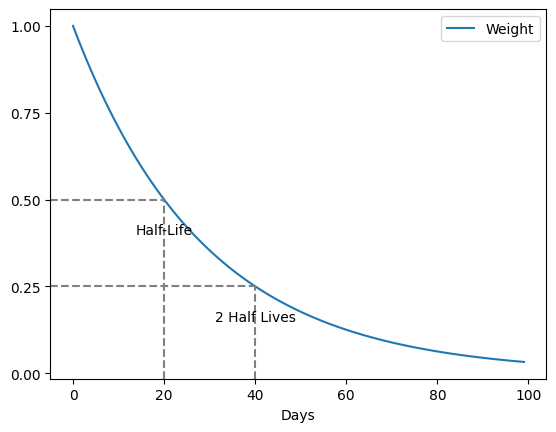

In [36]:
# Plot the half-life decay function

half_life = 20
x = np.arange(0, 100)
y = np.power(0.5, x / half_life)
df_halfLife = pd.DataFrame({'Days': x, 'Weight': y})

# Plot the function
ax = df_halfLife.plot(x='Days', y='Weight')

# Add vertical lines at 20 and 40 days with explanatory text
ax.set_yticks([0, 0.25, 0.5, 0.75, 1])
ax.axvline(x=20, linestyle='--', color='gray', ymax=0.49)
ax.axvline(x=40, linestyle='--', color='gray', ymax=0.25)
ax.axhline(y=0.5, linestyle='--', color='gray', xmax=0.23)
ax.axhline(y=0.25, linestyle='--', color='gray', xmax=0.41)
ax.text(20, 0.4, 'Half-Life', ha='center')
ax.text(40, 0.15, '2 Half Lives', ha='center')

plt.show()

In [37]:
# Get the timestamp of the most recent event in the df
last_date = df.agg(max('event_time')).collect()[0][0]
df = df.withColumn('last_date', lit(last_date))

# Calculate the recency of each event in terms of days
df = df.withColumn('recency', (col('last_date').cast('double') - col('event_time').cast('double')) / 86400)
df = df.drop('last_date')

# Half-life decay function, the value of an event is halved after 20 days
df = df.withColumn('recency_coef', expr('exp(ln(0.5)*recency/20)'))

In [38]:
# Find the number of views, carts and purchases for each user-product pair
interactions = df.groupby(['user_id', 'product_id']).agg(sum(when(df['event_type'] == 'view', 1) * df['recency_coef']).alias('views'),
                                                         sum(when(df['event_type'] == 'cart', 1) * df['recency_coef']).alias('carts'),
                                                         sum(when(df['event_type'] == 'purchase', 1) * df['recency_coef']).alias('purchases'))
interactions = interactions.na.fill(0)

A matriz de interações é construída atribuindo pesos a cada tipo de interação do utilizador. Estas interações são somadas, após serem ponderadas por uma **função de decaimento de meia-vida**, que valoriza eventos mais recentes.

O resultado é transformado com **logaritmo base 10** e limitado a um máximo de 100, para garantir escalabilidade, consistência e reduzir o impacto de outliers. A matriz final reflete a **força da relação** entre utilizadores e produtos.

In [39]:
def calculate_interaction_matrix(df, view_weight=0.1, cart_weight=0.3, purchase_weight=1.0):
 
    # Create a new column with the weighted interaction value
    df = df.withColumn('interaction', view_weight * col('views') + cart_weight * col('carts') + purchase_weight * col('purchases'))
    
    # Use log10 value for views, carts and purchases
    df = df.withColumn('interaction', log10(col('interaction') + 1))
    
    # Set the max possible value to 100 (log100 = 2)
    df = df.withColumn('interaction', when(col('interaction') > 2, 2).otherwise(col('interaction')))

    return df

In [40]:
interaction_matrix = calculate_interaction_matrix(interactions)

In [41]:
#  User-product pairs with the highest interaction scores

interaction_matrix.sort('interaction', ascending=False).show()

+---------+----------+------------------+------------------+------------------+------------------+
|  user_id|product_id|             views|             carts|         purchases|       interaction|
+---------+----------+------------------+------------------+------------------+------------------+
|519066729|   1005118| 29.96454010137684| 4.994845559629107|20.975188715286805| 1.422755522827899|
|572466543|   4804056|28.978723716516214| 5.995274629051174| 19.98354735610805| 1.409595055190172|
|518514099|   1005116|12.981238184801894|1.9963523385811377| 21.96517170950721| 1.395539577223198|
|521534312|   1003312|30.918042021253676| 4.989968651058472|11.975303820075133|1.2446258668816594|
|547227816|   1005130|11.960654956954855| 2.989934431622821|11.961206310611606|1.1776591855302592|
|557439628|   6600082|14.980413031567029| 3.993843790221238|10.982541287880514|1.1666886516323027|
|515567425|   1005138| 30.95711303726624| 3.994264570442948| 8.994357700974756|1.1549820305602871|
|569214412

Depois de criar uma matriz de interações ponderada entre utilizadores e produtos, esta pode ser usada pelo algoritmo **ALS** para aprender fatores latentes de ambos. Estes fatores permitem gerar **recomendações personalizadas**.

Depois de identificar o melhor conjunto de parâmetros, podemos treinar diretamente o modelo **ALS** sem recorrer novamente à validação cruzada. Esta abordagem é **mais eficiente**, poupando tempo e recursos ao gerar recomendações de produtos.

In [42]:
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator

def simple_als(interaction_matrix):
    
    # Train-test split
    (train, test) = interaction_matrix.randomSplit([0.8, 0.2])
    
    # Initialize the model with the optimized parameters
    als = ALS(userCol='user_id', itemCol='product_id', ratingCol='interaction', 
              alpha=1, regParam=0.005, rank=15, implicitPrefs=True, 
              nonnegative=True, coldStartStrategy='drop')

    # Fit the ALS model on the ratings data
    model = als.fit(train)
    
    # Make predictions
    predictions = model.transform(test)
    
    # Calculate the RMSE and MAE metrics
    evaluator = RegressionEvaluator(metricName='rmse', labelCol='interaction', predictionCol='prediction')
    rmse = evaluator.evaluate(predictions)
    mae = evaluator.setMetricName('mae').evaluate(predictions)
    print('test rmse:' + str(rmse) + ' mae:' + str(mae))
    
    return model

In [43]:
als_model = simple_als(interaction_matrix)

test rmse:0.11695812765063204 mae:0.07763972386534966


### 5.1. Recommend Products for Users

In [44]:
from pyspark.sql.functions import col
import random

# Obter todos os user_ids únicos
unique_users = interaction_matrix.select('user_id').distinct()

# Converter para uma lista de IDs
user_ids = [row['user_id'] for row in unique_users.collect()]

# Selecionar 3 IDs aleatórios
random_users = random.sample(user_ids, 3)

# Criar DataFrame com os utilizadores selecionados
user_subset_df = spark.createDataFrame([(user, 0) for user in random_users], ['user_id', 'product_id'])
user_subset_df.show()

+---------+----------+
|  user_id|product_id|
+---------+----------+
|542677210|         0|
|514486045|         0|
|515443408|         0|
+---------+----------+



In [45]:
# Gerar recomendações para os 3 utilizadores
recommendations = als_model.recommendForUserSubset(user_subset_df, 500)
recommendations.show(truncate=False)

+---------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [46]:
recommendations.show()

+---------+--------------------+
|  user_id|     recommendations|
+---------+--------------------+
|514486045|[{1801690, 4.3438...|
|515443408|[{1004833, 0.0045...|
|542677210|[{1004767, 0.9075...|
+---------+--------------------+



In [47]:
recs_for_user_1 = spark.createDataFrame(recommendations.collect()[1][1])

In [48]:
random_users

[542677210, 514486045, 515443408]

In [49]:
user = random_users[0]

In [50]:
# Products with the highest number of interactions for the user
interactions.filter(col('user_id') == user).sort('purchases', ascending=False).show()

+---------+----------+------------------+-----+---------+
|  user_id|product_id|             views|carts|purchases|
+---------+----------+------------------+-----+---------+
|542677210|   1004767|0.9962229205630214|  0.0|      0.0|
+---------+----------+------------------+-----+---------+



Ao gerar recomendações, podemos melhorar os scores de filtragem colaborativa (CF) ao integrar **características adicionais** que tornam as sugestões mais relevantes e personalizadas. Esta função combina o **score CF**, a **taxa de conversão** dos produtos e os **hábitos de consumo** dos utilizadores.

Os três scores são normalizados (entre 0 e 1) e combinados através de uma **média ponderada**, onde o peso do score CF é geralmente superior. Após a combinação, os valores são reescalados à sua escala original.

- **Score CF**: Indica o grau de afinidade entre o utilizador e o produto, aprendido pelo algoritmo ALS.
- **Taxa de Conversão**: Mede a proporção de compras por visualizações de um produto, favorecendo os que mais facilmente geram vendas.
- **Hábitos de Consumo**: Representam a média dos preços relativos dos produtos comprados pelo utilizador. Também aplicamos um *spending booster*, que dá uma ligeira preferência a produtos ligeiramente acima do hábito de consumo, incentivando o aumento de receita.

Com a afinação dos pesos, geramos recomendações **mais eficazes**, alinhadas com o perfil e comportamento do utilizador.

In [51]:
def calculate_recommendation_scores_for_user(user_id, recs, products, users, coef_als_score=0.8, coef_conversion_rate=0.1, coef_spending_habit=0.1, coef_spending_booster=0.05):
    # Join the recommendations with products data
    recs = recs.join(products[['product_id', 'purchase_per_view', 'relative_price']], on='product_id')
    
    # Get the user's average relative price, ensuring no None value is returned
    user_data = users.filter(col('user_id') == user_id).select('user_id', 'avg_relative_price_purchased').collect()
    
    if user_data:
        user_avg_relative_price = user_data[0][1]
    else:
        # Define a default value if the user does not exist in the data
        user_avg_relative_price = 0  # Or any other default value you prefer
    
    # Check if user_avg_relative_price is None and assign a default value
    if user_avg_relative_price is None:
        user_avg_relative_price = 0  # Or another appropriate default value
    
    # Scale CF rating score, ranges from 0 to 2
    recs = recs.withColumn('rating', col('rating') / 2)
    
    # Scale purchase_per_view rate, ranges from 0 to 0.075
    recs = recs.withColumn('purchase_per_view', col('purchase_per_view') / 0.075)
    
    # Scale relative price value, ranges from -5 to 5
    recs = recs.withColumn('relative_price', (col('relative_price') + 5) / 10)
    
    # Scale users average relative price value, ranges from -1 to 1
    user_avg_relative_price = (user_avg_relative_price + 1) / 2
    
    # Calculate the recommendation scores
    recs = recs.withColumn('recommendation_score', 
                           ((col('rating') * coef_als_score) + 
                            (col('purchase_per_view') * coef_conversion_rate) - 
                            abs(user_avg_relative_price + coef_spending_booster - col('relative_price')) * coef_spending_habit) / 
                            (coef_als_score + coef_conversion_rate + coef_spending_habit)
                          )
    
    # Scale back CF rating score, ranges from 0 to 2
    recs = recs.withColumn('rating', col('rating') * 2)

    # Scale back purchase_per_view rate, ranges from 0 to 0.075
    recs = recs.withColumn('purchase_per_view', col('purchase_per_view') * 0.075)
    
    # Scale back relative price value, ranges from -1 to 1
    recs = recs.withColumn('relative_price', col('relative_price') * 2 - 1)

    # Scale back average relative price value, ranges from -5 to 5
    user_avg_relative_price = user_avg_relative_price * 10 - 5
    
    return recs

In [52]:
recs_user = calculate_recommendation_scores_for_user(user, recs_for_user_1, products, users)

In [53]:
# Add all product features to the recommendations dataframe

#recs_user = recs_user.join(product_features, on='product_id', how='left')

In [54]:
# Products with the highest recommendation scores

recs_user.sort('recommendation_score', ascending=False).show()

+----------+--------------------+-------------------+--------------------+--------------------+
|product_id|              rating|  purchase_per_view|      relative_price|recommendation_score|
+----------+--------------------+-------------------+--------------------+--------------------+
|   1002544|0.002160558709874749| 0.1211022480058013| 0.09796756309927201|  0.1622322656466486|
|   1004856|0.002326230984181...| 0.1251798561151079|-0.04459157319152851|  0.1606073885542399|
|   4803977|2.724451478570699...|0.11595232303575773| 0.17875461331284814| 0.15077434477451074|
|   1005118|5.799252539873123E-5|0.11753731343283583|  0.2814083444896318| 0.14766919769612566|
|   4100346|1.995186466956511...|  0.116991643454039| -0.1507569834387763|  0.1435308162254581|
|   1005212|6.549655226990581E-4|0.11127840371887805|-0.02565772035637...|   0.142350305149765|
|   1004833| 0.00452541746199131|0.10581662832730858|-0.02481152267761...|  0.1366584286206605|
|   1002524|1.039065173245035...|0.10242

Para melhorar a **relevância e novidade** das recomendações, podemos filtrar os resultados para incluir apenas produtos **não previamente interagidos**. Isto significa excluir produtos que o utilizador já visualizou, adicionou ao carrinho ou comprou, bem como produtos pelos quais demonstrou desinteresse.

Este processo permite criar secções dedicadas como **"Novidades para Si"** ou **"Descubra Algo Diferente"**, focadas em apresentar opções **frescas e inéditas**. Desta forma, o utilizador tem oportunidade de explorar novos produtos e evitar recomendações repetitivas.

Este passo de filtragem garante que as recomendações são mais **personalizadas** e **exploratórias**, promovendo uma melhor experiência de utilizador e aumentando a probabilidade de descoberta de algo novo e apelativo.

In [55]:
# Filter non-interacted products in recommendations using left-anti join
non_interacted_products = recs_user.join(interactions.filter(col('user_id') == user), on='product_id', how='leftanti')

# Non-interacted products with the highest recommendation scores
non_interacted_products.sort('recommendation_score', ascending=False).show()

+----------+--------------------+-------------------+--------------------+--------------------+
|product_id|              rating|  purchase_per_view|      relative_price|recommendation_score|
+----------+--------------------+-------------------+--------------------+--------------------+
|   1002544|0.002160558709874749| 0.1211022480058013| 0.09796756309927201|  0.1622322656466486|
|   1004856|0.002326230984181...| 0.1251798561151079|-0.04459157319152851|  0.1606073885542399|
|   4803977|2.724451478570699...|0.11595232303575773| 0.17875461331284814| 0.15077434477451074|
|   1005118|5.799252539873123E-5|0.11753731343283583|  0.2814083444896318| 0.14766919769612566|
|   4100346|1.995186466956511...|  0.116991643454039| -0.1507569834387763|  0.1435308162254581|
|   1005212|6.549655226990581E-4|0.11127840371887805|-0.02565772035637...|   0.142350305149765|
|   1004833| 0.00452541746199131|0.10581662832730858|-0.02481152267761...|  0.1366584286206605|
|   1002524|1.039065173245035...|0.10242

### 5.3. Recommend Products for Products

Quando um utilizador está a visualizar um produto específico, podemos melhorar a sua experiência de compra ao recomendar **produtos semelhantes**. Estas recomendações são focadas **no produto em si**, e não nas preferências individuais do utilizador.

Para tal, utilizamos o algoritmo **ALS**, que calcula fatores latentes dos produtos com base nas interações. Estes fatores refletem características intrínsecas dos produtos, permitindo compreender as suas **semelhanças subjacentes**.

Convertendo estes fatores em **vetores num espaço multidimensional**, aplicamos o algoritmo **Locality-Sensitive Hashing (LSH)** para identificar, de forma eficiente, vetores próximos — ou seja, produtos com **características semelhantes**.

Desta forma, conseguimos recomendar produtos que partilham atributos relevantes, sejam **alternativas dentro da mesma categoria** ou **itens complementares** de outras categorias.

Este tipo de recomendação ajuda os utilizadores a descobrir **novas opções relevantes**, enriquecendo a sua experiência e aumentando a diversidade dos produtos apresentados.

In [56]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import Normalizer
from pyspark.ml.feature import SQLTransformer

# Get the product factors from the ALS model
product_vectors = als_model.itemFactors
product_vectors = product_vectors.rdd.map(lambda row: (row[0], Vectors.dense(row[1])))
product_vectors = product_vectors.toDF(['product_id', 'features'])

# Use VectorAssembler to convert the features column into a dense vector column
assembler = VectorAssembler(inputCols=['features'], outputCol='vector')
product_vectors = assembler.transform(product_vectors)

# Normalize the vectors
normalizer = Normalizer(inputCol='vector', outputCol='norm_vector')
product_vectors = normalizer.transform(product_vectors)
product_vectors.show(truncate=False)

+----------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|product_id|features                                                                                                                                                                                                                                  

In [57]:
product_vectors.select('product_id').show(truncate=False)

+----------+
|product_id|
+----------+
|1002100   |
|1002540   |
|1003050   |
|1003230   |
|1003310   |
|1003710   |
|1003750   |
|1003770   |
|1003800   |
|1003860   |
|1003870   |
|1003890   |
|1003910   |
|1004060   |
|1004080   |
|1004090   |
|1004140   |
|1004190   |
|1004210   |
|1004230   |
+----------+
only showing top 20 rows



In [58]:
# Selecionar um 'product_id' aleatório
random_product = product_vectors.select('product_id').orderBy(F.rand()).limit(1)

# Mostrar o resultado
random_product_id = random_product.collect()[0]['product_id']
random_product_id

1701359

In [59]:
# Get the normalized vector representation of the selected product
product_vector = product_vectors.where(col('product_id') == random_product_id).select('norm_vector').collect()[0][0]
product_vector

SparseVector(15, {2: 0.9957, 6: 0.0921})

O algoritmo **LSH (Locality-Sensitive Hashing)** é uma técnica utilizada para **pesquisa aproximada dos vizinhos mais próximos** em espaços de alta dimensão, com grande eficiência computacional.

O LSH funciona projetando aleatoriamente os dados de alta dimensão para um **espaço de menor dimensão**, através de funções de hash. O seu princípio baseia-se no facto de que **itens semelhantes têm maior probabilidade de cair no mesmo balde (bucket)**, enquanto itens diferentes tendem a ser separados em baldes distintos. Esta estratégia permite **reduzir drasticamente o espaço de procura**, limitando a busca aos candidatos que partilham o mesmo balde.

Os principais parâmetros do LSH são:

- **`numHashTables`**: Define o número de tabelas de hash utilizadas. Um número mais elevado de tabelas **melhora a precisão** da pesquisa, mas também **aumenta o custo computacional**.
- **`bucketLength`**: Controla o tamanho dos baldes. Baldes mais pequenos oferecem **maior precisão**, mas exigem mais recursos de processamento.

O LSH é, assim, uma solução eficaz para encontrar rapidamente produtos semelhantes em sistemas de recomendação com **grandes volumes de dados** e elevada dimensionalidade.

In [60]:
from pyspark.ml.feature import BucketedRandomProjectionLSH

brp = BucketedRandomProjectionLSH(inputCol="norm_vector", outputCol="neighbors", numHashTables=5, bucketLength=0.1)
brp_model = brp.fit(product_vectors)

# Find the nearest neighbors of a specific product
query = product_vectors.filter(col('product_id') == random_product_id).select('norm_vector').first()[0]
neighbors = brp_model.approxNearestNeighbors(product_vectors, query, numNearestNeighbors=50)

In [61]:
# Print the most similar products, the first entry is the product itself
neighbors.select('product_id', 'distCol').show(truncate=False)

+----------+---------------------+
|product_id|distCol              |
+----------+---------------------+
|1701359   |0.0                  |
|6000212   |0.0050025295162650215|
|6100262   |0.005066895770901003 |
|6000174   |0.005669925516850492 |
|16700477  |0.0646261594145208   |
|16700470  |0.09124319765757369  |
|17800202  |0.09222645200418093  |
|15400073  |0.09222645200418093  |
|34800332  |0.09222645200418093  |
|2501847   |0.09222645200418093  |
|11600432  |0.09222645200418093  |
|6400383   |0.09222645200418093  |
|11900182  |0.09222645200418093  |
|1004015   |0.09222645200418093  |
|13700202  |0.09222645200418093  |
|13300063  |0.09222645200418093  |
|15400282  |0.09222645200418093  |
|7005357   |0.09222645200418093  |
|21411512  |0.09222645200418093  |
|100000443 |0.09222645200418093  |
+----------+---------------------+
only showing top 20 rows



Quando calculamos os **scores de recomendação para produtos**, utilizamos uma abordagem semelhante à usada nas recomendações para utilizadores. Medimos a **semelhança entre produtos** com base na **distância cosseno** e combinamos essa informação com outras características, como a **taxa de conversão** e o **preço relativo**.

A função funciona de forma similar ao processo de recomendação para utilizadores, mas com uma pequena diferença. Em vez de calcular os **hábitos de gasto dos utilizadores**, consideramos o **preço relativo** do produto que está a ser visualizado. Isso ajuda a encontrar produtos que apresentam **faixas de preço semelhantes**.

In [62]:
def calculate_recommendation_scores_for_products(recs, products, coef_distance_score=0.8, coef_conversion_rate=0.1, coef_relative_price=0.1, coef_spending_booster=0.05):
   
    recs = recs.join(products['product_id', 'purchase_per_view', 'relative_price'], on='product_id')
     
    # Scale distance of nearest neigbors in the unit vector space, ranges from 0 to sqrt(2)
    recs = recs.withColumn('distCol', (math.sqrt(2) - col('distCol')) / math.sqrt(2))
    
    # Scale purchase_per_view rate, ranges from 0 to 0.075
    recs = recs.withColumn('purchase_per_view', col('purchase_per_view') / 0.075)
    
    # Scale relative price value, ranges from -5 to 5
    recs = recs.withColumn('relative_price', (col('relative_price') + 5) / 10)
    
    # Find the relative price of the chosen product
    product_relative_price = recs.filter(col('distCol') == 1)['product_id', 'relative_price'].collect()[0][1]

    # Scale product's average relative price value, ranges from -5 to 5
    product_relative_price = (product_relative_price + 5) / 10
    

    # Calculate the recommendation scores
    recs = recs.withColumn('recommendation_score', ((recs['distCol'] * coef_distance_score) + (recs['purchase_per_view'] * coef_conversion_rate) - abs(product_relative_price + coef_spending_booster - recs['relative_price']) * coef_relative_price) / (coef_distance_score + coef_conversion_rate + coef_relative_price)) 

    # Remove the searched product from the recommendations
    recs = recs.filter(col('distCol') != 1)
    
    
    # Scale back distance of nearest neigbors in the unit vector space, ranges from 0 to sqrt(2)
    recs = recs.withColumn('distCol', math.sqrt(2) - col('distCol') * math.sqrt(2))
    
    # Scale back purchase_per_view rate, ranges from 0 to 0.075
    recs = recs.withColumn('purchase_per_view', col('purchase_per_view') * 0.075)
    
    # Scale back relative price value, ranges from -5 to 5
    recs = recs.withColumn('relative_price', col('relative_price') * 10 - 5)

    # Scale product's average relative price value, ranges from -5 to 5
    product_relative_price = product_relative_price * 10 - 5
    
    return recs

In [63]:
recs_product = calculate_recommendation_scores_for_products(neighbors.select('product_id', 'distCol'), products)

In [64]:
# Add all product features to the recommendations dataframe

#recs_product = recs_product.join(product_features, on='product_id', how='left')

In [65]:
# Display recommendations with Pandas

recs_product.sort('recommendation_score', ascending=False).toPandas() \
    .style.bar(color='lightgreen', subset='distCol') \
    .bar(color='pink', subset='purchase_per_view') \
    .bar(color='tan', subset='relative_price') \
    .bar(color='lightblue', subset='recommendation_score')


,product_id,distCol,purchase_per_view,relative_price,recommendation_score
0,6000212,0.005003,0.047621,1.034046,0.860479
1,6000174,0.005670,0.047191,0.311843,0.852678
2,1004015,0.092226,0.069741,0.881385,0.839477
3,6100262,0.005067,0.039299,2.153714,0.838149
4,100000021,0.092226,0.054205,1.406557,0.816192
5,12703044,0.092226,0.057217,-0.169885,0.812265
6,1005105,0.092226,0.054865,2.176888,0.809368
7,45400115,0.092226,0.038027,1.116884,0.797517
8,17302950,0.092226,0.042262,0.249500,0.796519
9,27800080,0.092226,0.037849,0.680956,0.794950


### 5.3. Recommend Products to Users Viewing a Product

Ao combinar ambas as abordagens de recomendar produtos aos utilizadores e encontrar produtos semelhantes, podemos criar um sistema de recomendação mais **personalizado**. Isso permite sugerir produtos que são não só **relevantes para as preferências** do utilizador, mas também semelhantes ao produto que estão a visualizar no momento.

Utilizando o **filtragem colaborativa** e os **dados históricos do utilizador**, geramos recomendações adaptadas aos seus gostos individuais. Simultaneamente, utilizamos a **análise de semelhança de produtos**, considerando fatores como a **distância cosseno** e outras características relevantes. Isso permite sugerir produtos semelhantes ao que o utilizador está a explorar, criando uma experiência mais **personalizada e envolvente**.

Em essência, esta abordagem híbrida combina os benefícios das **recomendações personalizadas** e da **identificação de produtos semelhantes**, resultando num sistema de recomendação **abrangente** e **eficaz**.

In [66]:
# Join the two recommendation dataframes, top 50 most similar products and top 500 recs for the user

recs_user = recs_user.withColumnRenamed('recommendation_score', 'recommendation_score_user')
recs_paired = recs_product.join(recs_user['product_id', 'recommendation_score_user'], on='product_id', how='inner')

In [67]:
recs_user.show(truncate=False)

+----------+---------------------+--------------------+---------------------+-------------------------+
|product_id|rating               |purchase_per_view   |relative_price       |recommendation_score_user|
+----------+---------------------+--------------------+---------------------+-------------------------+
|3900002   |3.3246400562347844E-5|0.07027214988885361 |-0.011750012500999496|0.0881219977869798       |
|3900003   |3.615667810663581E-5 |0.05354747538901238 |0.019608802635194156 |0.06739153665501887      |
|22300003  |5.6005188525887206E-5|0.04771682810595867 |0.0                  |0.05864483955002191      |
|5100562   |3.6051980714546517E-5|0.06938126829268293 |0.016922182512801642 |0.08836888764150314      |
|5100566   |5.729127224185504E-5 |0.06408721951219512 |0.10174396583610035  |0.0853853442333519       |
|5100577   |6.125034269643947E-5 |0.053104585365853656|0.008391664655243325 |0.06625019719097895      |
|5100610   |4.229451224091463E-5 |0.06384546341463415 |0.0156769

In [68]:
recs_product.show(truncate=False)

+----------+---------------------+--------------------+--------------------+--------------------+
|product_id|distCol              |purchase_per_view   |relative_price      |recommendation_score|
+----------+---------------------+--------------------+--------------------+--------------------+
|10301484  |0.09222645200418089  |0.032945357087449736|-0.12793941809485876|0.7803221736651057  |
|10300030  |0.09222645200418089  |0.03311157987800196 |-0.1538461538461542 |0.7802847366949958  |
|12703044  |0.09222645200418089  |0.05721691678035471 |-0.1698853823206159 |0.8122647936133882  |
|17302950  |0.09222645200418089  |0.04226232144546401 |0.2494998571020286  |0.7965191855610937  |
|4900344   |0.09222645200418089  |0.03214270456374181 |0.7628580471593605  |0.788159944952704   |
|1004015   |0.09222645200418089  |0.06974133312322724 |0.8813846903949285  |0.8394767161310404  |
|1005105   |0.09222645200418089  |0.054864864864864867|2.1768883982732667  |0.8093675247205414  |
|29300551  |0.092226

Ao encontrar os produtos mais semelhantes, é importante notar que nem todos terão uma **pontuação de recomendação** correspondente. Isto ocorre porque calculamos as pontuações apenas para os **top 500 produtos**, especificamente para os utilizadores. Como resultado, alguns dos **top 50 produtos semelhantes** podem não ter pontuações de utilizador disponíveis.

Para lidar com esta situação, é necessário atribuir **pontuações substitutas** para os produtos sem pontuações de utilizador. Uma abordagem simples seria preencher essas pontuações com uma versão ligeiramente reduzida da **pontuação mais baixa**. Isso garante que os produtos sem pontuações de utilizador ainda recebam alguma consideração no processo de recomendação.

In [69]:
recs_paired.show(truncate=False)

+----------+-------------------+--------------------+------------------+--------------------+-------------------------+
|product_id|distCol            |purchase_per_view   |relative_price    |recommendation_score|recommendation_score_user|
+----------+-------------------+--------------------+------------------+--------------------+-------------------------+
|1005105   |0.09222645200418089|0.054864864864864867|2.1768883982732667|0.8093675247205414  |0.056485212581655266     |
+----------+-------------------+--------------------+------------------+--------------------+-------------------------+



In [70]:
# Fill missing user-based recommendation scores with 10% less of the lowest recommendation score
min_user_score = recs_paired.select(min('recommendation_score_user')).collect()[0][0]
recs_paired = recs_paired.na.fill(min_user_score * 0.9)

# Calculate a paired score as the average of the recommendation score and user score, weighted equally
recs_paired = recs_paired.withColumn('paired_score', col('recommendation_score') * 0.5 + col('recommendation_score_user') * 0.5)


In [71]:
# Add all product features to the recommendations dataframe

#recs_paired = recs_paired.join(product_features, on='product_id', how='left')

In [72]:
recs_paired.sort('paired_score', ascending=False).toPandas()\
           .head(50).style.bar(color='lightblue', subset='recommendation_score')\
           .bar(color='pink', subset='recommendation_score_user')\
           .bar(color='lightgreen', subset='paired_score')


,product_id,distCol,purchase_per_view,relative_price,recommendation_score,recommendation_score_user,paired_score
0,1005105,0.092226,0.054865,2.176888,0.809368,0.056485,0.432926


Em conclusão, o **motor de recomendação** que desenvolvemos combina **filtragem colaborativa** com características adicionais para gerar recomendações de produtos personalizadas e envolventes. Ao incorporar fatores como **taxas de conversão**, **hábitos de consumo** e **semelhança de produtos**, o objetivo é fornecer aos utilizadores sugestões relevantes, adaptadas às suas preferências.

Quando o motor de recomendação é **implementado**, ele aprende continuamente com as interações dos utilizadores e atualiza as recomendações em conformidade, dando mais peso às interações recentes. À medida que os utilizadores interagem com o sistema, o seu feedback influencia os pesos e a relevância de diferentes características, tornando as recomendações mais precisas e alinhadas com as preferências dos utilizadores ao longo do tempo. Essa natureza dinâmica assegura que as recomendações permaneçam relevantes e reflictam os interesses em evolução dos utilizadores.

Para avaliar o desempenho das nossas recomendações, podemos utilizar diversas **métricas** como **taxas de cliques**, **taxas de conversão** e **feedback dos utilizadores**. Essas métricas fornecem uma visão sobre a eficácia das recomendações e ajudam a avaliar o seu impacto no **engajamento dos utilizadores** e nas **vendas**.

Com base nas métricas de desempenho, podemos tomar decisões informadas para ajustar a **estratégia de recomendação**. Por exemplo, se um produto recebe pouco **engajamento** apesar de ser recomendado frequentemente, podemos reavaliar a sua posição na lista de recomendações. Ao colocá-lo mais abaixo ou até removê-lo temporariamente, podemos melhorar a eficácia geral das recomendações e priorizar produtos mais envolventes.

Ao monitorizar e analisar ativamente as métricas de desempenho, podemos aprimorar iterativamente o motor de recomendação, otimizar o **peso das características** e ajustar os algoritmos para fornecer recomendações mais **personalizadas**, **precisas** e **impactantes**.

No geral, este motor de recomendação utiliza a **filtragem colaborativa**, **características adicionais** e **feedback dos utilizadores** para criar um sistema dinâmico e eficaz que melhora a **experiência do utilizador**, aumenta o **engajamento** e impulsiona as **vendas** ao sugerir produtos relevantes, adaptados às preferências de cada utilizador.